<a href="https://colab.research.google.com/github/elijahcw-git/Capstone/blob/main/Crime_Hotspot_Prediction_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!pip install category_encoders


Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 3.0 MB/s eta 0:00:00


In [3]:
#Import dataset:

crime_df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/crime_clean.csv')
print(crime_df.shape)

(2883802, 26)


In [4]:
print(f"Dataset shape :{crime_df.shape}\n")


missing_values = crime_df.isnull().sum()
percentage_missing = (missing_values / len(crime_df)) * 100
unique_values = crime_df.nunique()
summary_df = print(pd.DataFrame({'Data_type': crime_df.dtypes,'Missing': missing_values, '%_Missing': percentage_missing, 'Unique_values': unique_values}))

print(summary_df)

Dataset shape :(2883802, 26)

                     Data_type  Missing  %_Missing  Unique_values
DR_NO                    int64        0        0.0        2555000
Date_Rptd               object        0        0.0           5129
DATE_OCC                object        0        0.0           5111
TIME_OCC                 int64        0        0.0           1439
AREA                     int64        0        0.0             21
AREA_NAME               object        0        0.0             21
Rpt_Dist_No              int64        0        0.0           1302
Part_1-2                 int64        0        0.0              2
Crm_Cd                   int64        0        0.0            144
Crm_Cd_Desc             object        0        0.0            144
Vict_Age               float64        0        0.0             99
Vict_Sex                object        0        0.0              3
Vict_Descent            object        0        0.0             21
LOCATION                object        0       

In [5]:
crime_df['DATE_OCC'] = pd.to_datetime(crime_df['DATE_OCC'])
crime_df.head(5)

,DR_NO,Date_Rptd,DATE_OCC,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,...,Avg_Temp,Avg_Dewpoint,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin
0,1307355,02/20/2010 12:00:00 AM,2010-02-20,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,...,56.1,47.5,73.2,9.7,29.8,0.0,0,Violations and Restraining Orders,7,Hispanic/Latin/Mexican
1,100100638,02/20/2010 12:00:00 AM,2010-02-20,100,1,Central,164,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",...,56.1,47.5,73.2,9.7,29.8,0.0,0,Vandalism and Property Damage,6,Other
2,100100639,02/20/2010 12:00:00 AM,2010-02-20,230,1,Central,164,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,...,56.1,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican
3,100106650,02/20/2010 12:00:00 AM,2010-02-20,45,1,Central,155,2,624,BATTERY - SIMPLE ASSAULT,...,56.1,47.5,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black
4,100106654,02/20/2010 12:00:00 AM,2010-02-20,1130,1,Central,146,2,946,OTHER MISCELLANEOUS CRIME,...,56.1,47.5,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican


In [6]:
crime_df.set_index('DATE_OCC', inplace=True)

In [7]:
# Convert the following into categorical

crime_df['AREA_NAME'] = crime_df['AREA_NAME'].astype('category')

In [8]:
crime_df['Crime_Incidence'] = crime_df.groupby(['AREA_NAME', 'DATE_OCC'])['AREA_NAME'].transform('count')

In [9]:
area_mapping = {
    'Central': 'Central_Bureau', 'Hollenbeck': 'Central_Bureau', 'Newton': 'Central_Bureau', 'Northeast': 'Central_Bureau', 'Rampart': 'Central_Bureau',
    '77th Street': 'South_Bureau', 'Harbor': 'South_Bureau', 'Southeast': 'South_Bureau', 'Southwest': 'South_Bureau',
    'Hollywood': 'West_Bureau', 'Olympic': 'West_Bureau', 'Pacific': 'West_Bureau', 'West Los Angeles': 'West_Bureau', 'Wilshire': 'West_Bureau',
    'Devonshire': 'Valley_Bureau', 'Foothill': 'Valley_Bureau', 'Mission': 'Valley_Bureau', 'N Hollywood': 'Valley_Bureau', 'Topanga': 'Valley_Bureau', 'Van Nuys': 'Valley_Bureau', 'West Valley': 'Valley_Bureau',
}
# Creating the new variable, BUREAU.

crime_df['BUREAU'] = crime_df['AREA_NAME'].map(area_mapping)

In [10]:
crime_df.head(20)

,DR_NO,Date_Rptd,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,Vict_Age,...,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Crime_Incidence,BUREAU
DATE_OCC,,,,,,,,,,,,,,,,,,,,,
2010-02-20,1307355,02/20/2010 12:00:00 AM,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,48.0,...,73.2,9.7,29.8,0.0,0,Violations and Restraining Orders,7,Hispanic/Latin/Mexican,38,Central_Bureau
2010-02-20,100100638,02/20/2010 12:00:00 AM,100,1,Central,164,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0.0,...,73.2,9.7,29.8,0.0,0,Vandalism and Property Damage,6,Other,16,Central_Bureau
2010-02-20,100100639,02/20/2010 12:00:00 AM,230,1,Central,164,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,25.0,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,16,Central_Bureau
2010-02-20,100106650,02/20/2010 12:00:00 AM,45,1,Central,155,2,624,BATTERY - SIMPLE ASSAULT,53.0,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,16,Central_Bureau
2010-02-20,100106654,02/20/2010 12:00:00 AM,1130,1,Central,146,2,946,OTHER MISCELLANEOUS CRIME,18.0,...,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican,16,Central_Bureau
2010-02-20,100106660,02/20/2010 12:00:00 AM,1200,1,Central,165,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",46.0,...,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Other,16,Central_Bureau
2010-02-20,100106674,02/20/2010 12:00:00 AM,1645,1,Central,182,2,930,CRIMINAL THREATS - NO WEAPON DISPLAYED,21.0,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,16,Central_Bureau
2010-02-20,100106675,02/20/2010 12:00:00 AM,1100,1,Central,192,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,49.0,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Hispanic/Latin/Mexican,16,Central_Bureau
2010-02-20,100106677,02/20/2010 12:00:00 AM,1400,1,Central,161,1,440,THEFT PLAIN - PETTY ($950 & UNDER),35.0,...,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Black,16,Central_Bureau


In [11]:
crime_df.shape

(2883802, 27)

In [12]:
# Convert the following into categorical

crime_df['BUREAU'] = crime_df['BUREAU'].astype('category')

In [13]:
crime_df['BUREAU'].value_counts()

Valley_Bureau     898134
Central_Bureau    669719
South_Bureau      640506
West_Bureau       548001
Name: BUREAU, dtype: int64

<Figure size 1200x600 with 0 Axes>

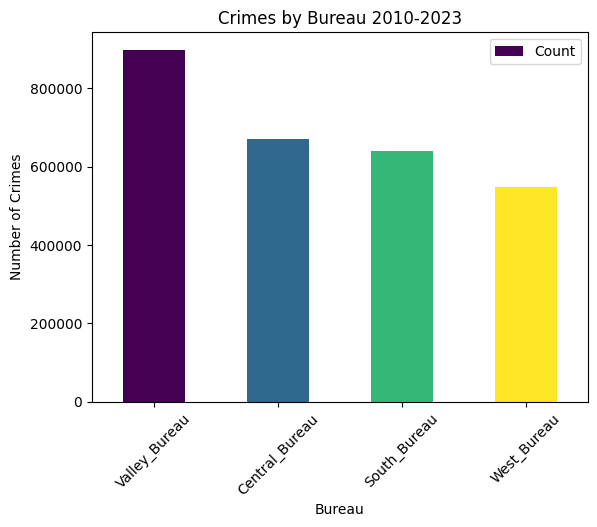

In [14]:
# Group by BUREAU and count the number of crimes
crimes_by_bureau = crime_df.groupby('BUREAU')['DR_NO'].count().reset_index(name='Count')


# Sort by crime count
crimes_by_bureau = crimes_by_bureau.sort_values('Count', ascending=False)

# Generate a list of colors
colors = plt.cm.viridis(np.linspace(0, 1, len(crimes_by_bureau)))

# Create a bar chart
plt.figure(figsize=(12, 6))
crimes_by_bureau.plot(kind='bar', x='BUREAU', y='Count', color=colors)

# Add labels and title
plt.title('Crimes by Bureau 2010-2023')
plt.xlabel('Bureau')
plt.ylabel('Number of Crimes')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the bar chart
plt.show()




In [15]:
# To split crime_df into four separate datasets based on bureau category.

split_datasets = {}

categories = crime_df['BUREAU'].unique()
for category in categories:
  split_datasets[category] = crime_df[crime_df['BUREAU'] ==category]

central_dataset = split_datasets['Central_Bureau']
west_dataset = split_datasets['West_Bureau']
south_dataset = split_datasets['South_Bureau']
valley_dataset = split_datasets['Valley_Bureau']

In [16]:
south_dataset.head()

,DR_NO,Date_Rptd,TIME_OCC,AREA,AREA_NAME,Rpt_Dist_No,Part_1-2,Crm_Cd,Crm_Cd_Desc,Vict_Age,...,Avg_Humidity,Avg_Windspeed,Avg_Pressure,Total_Precipitation,Weapon_Reported,Crime_Category,Crime_Category_Code,Region_Ethnic_Origin,Crime_Incidence,BUREAU
DATE_OCC,,,,,,,,,,,,,,,,,,,,,
2010-02-20,100300676,02/20/2010 12:00:00 AM,40,3,Southwest,362,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,38.0,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,42,South_Bureau
2010-02-20,100300678,02/20/2010 12:00:00 AM,1640,3,Southwest,363,1,310,BURGLARY,23.0,...,73.2,9.7,29.8,0.0,0,Theft and Burglary,5,Black,42,South_Bureau
2010-02-20,100300680,02/20/2010 12:00:00 AM,1015,3,Southwest,311,2,624,BATTERY - SIMPLE ASSAULT,33.0,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,42,South_Bureau
2010-02-20,100307420,02/21/2010 12:00:00 AM,1300,3,Southwest,397,1,420,THEFT FROM MOTOR VEHICLE - PETTY ($950 & UNDER),45.0,...,73.2,9.7,29.8,0.0,0,Miscellaneous Crimes,2,Hispanic/Latin/Mexican,42,South_Bureau
2010-02-20,100307356,02/20/2010 12:00:00 AM,145,3,Southwest,363,2,626,INTIMATE PARTNER - SIMPLE ASSAULT,60.0,...,73.2,9.7,29.8,0.0,1,"Assault, Battery and Other Violent",0,Black,42,South_Bureau


In [17]:
crime_df.shape[0]

2883802

**Using ARIMA to Predict Crime Incidence**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from pandas.plotting import autocorrelation_plot

In [19]:
!pip install pmdarima
from pmdarima.arima import auto_arima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.2 MB/s eta 0:00:00


In [20]:
from pathlib import Path
import math
from math import floor,ceil,sqrt
import datetime as dt

import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, roc_curve, auc
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import preprocessing

**Full Dataset (All Bureaus)**

In [21]:
# Split the data into train and test sets
train_set = int(len(crime_df) * 0.8)
train, test = crime_df[:train_set], crime_df[train_set:]

# Find the optimal order (p, d, q) for ARIMA model based on AIC or other criteria
# Here, we use the order (2, 1, 3) as an example
order = (2, 1, 3)

# Train the ARIMA model
model = ARIMA(train['Crime_Incidence'], order=order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Evaluate the model using mean squared error
mse = mean_squared_error(test['Crime_Incidence'], predictions)
rmse = np.sqrt(mse)
print('RMSE: %.2f' % rmse)

RMSE: 31.26


---------------------------------------------------------------------------
-----------L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------
---------------------------------------------------------------------------
Shape of Training Set (2307042, 1)
Shape of Validation Set (576760, 1)
RMSE value on validation set: 31.25960625518246


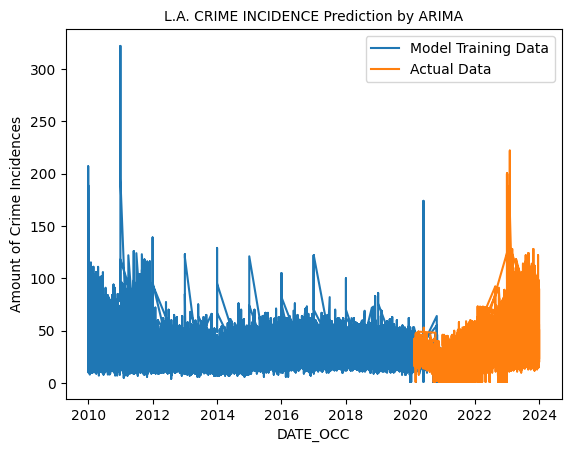

In [22]:
shape=crime_df.shape[0]
df_new=crime_df[['Crime_Incidence']]
df_new.head()
train_set=df_new.iloc[:ceil(shape*0.80)]
valid_set=df_new.iloc[ceil(shape*0.80):]
print('---------------------------------------------------------------------------')
print('-----------L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------')
print('---------------------------------------------------------------------------')
print('Shape of Training Set',train_set.shape)
print('Shape of Validation Set',valid_set.shape)
print('RMSE value on validation set:',rmse)


plt.plot(train_set['Crime_Incidence'])
plt.plot(valid_set['Crime_Incidence'])
plt.xlabel('DATE_OCC',size=10)
plt.ylabel('Amount of Crime Incidences',size=10)
plt.title('L.A. CRIME INCIDENCE Prediction by ARIMA',size=10)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

**ARIMA for West Bureau**

In [23]:
# Split the data into train and test sets
train_set = int(len(west_dataset) * 0.8)
train, test = west_dataset[:train_set], west_dataset[train_set:]

# Find the optimal order (p, d, q) for ARIMA model based on AIC or other criteria
# Here, we use the order (2, 1, 3) as an example
order = (2, 1, 3)

# Train the ARIMA model
model = ARIMA(train['Crime_Incidence'], order=order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Evaluate the model using mean squared error
mse = mean_squared_error(test['Crime_Incidence'], predictions)
rmse = np.sqrt(mse)
print('RMSE: %.2f' % rmse)

RMSE: 42.65


---------------------------------------------------------------------------
-----------WEST BUREAU OF L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------
---------------------------------------------------------------------------
Shape of Training Set (438401, 1)
Shape of Validation Set (109600, 1)
RMSE value on validation set: 42.64545435579244


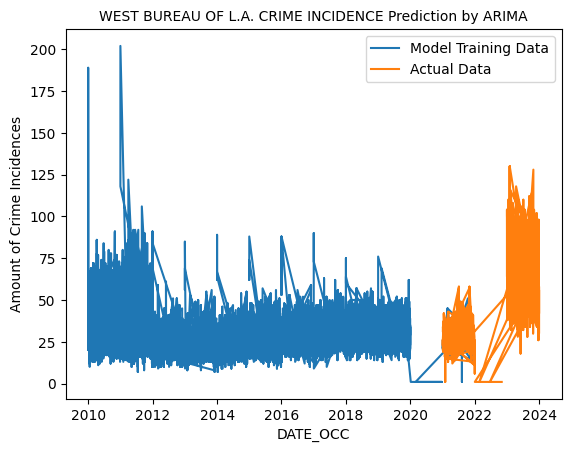

In [24]:
shape=west_dataset.shape[0]
df_new=west_dataset[['Crime_Incidence']]
df_new.head()
train_set=df_new.iloc[:ceil(shape*0.80)]
valid_set=df_new.iloc[ceil(shape*0.80):]
print('---------------------------------------------------------------------------')
print('-----------WEST BUREAU OF L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------')
print('---------------------------------------------------------------------------')
print('Shape of Training Set',train_set.shape)
print('Shape of Validation Set',valid_set.shape)
print('RMSE value on validation set:',rmse)


plt.plot(train_set['Crime_Incidence'])
plt.plot(valid_set['Crime_Incidence'])
plt.xlabel('DATE_OCC',size=10)
plt.ylabel('Amount of Crime Incidences',size=10)
plt.title('WEST BUREAU OF L.A. CRIME INCIDENCE Prediction by ARIMA',size=10)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

**ARIMA for South Bureau**

In [25]:
# Split the data into train and test sets
train_set = int(len(south_dataset) * 0.8)
train, test = south_dataset[:train_set], south_dataset[train_set:]

# Find the optimal order (p, d, q) for ARIMA model based on AIC or other criteria
# Here, we use the order (2, 1, 3) as an example
order = (2, 1, 3)

# Train the ARIMA model
model = ARIMA(train['Crime_Incidence'], order=order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Evaluate the model using mean squared error
mse = mean_squared_error(test['Crime_Incidence'], predictions)
rmse = np.sqrt(mse)
print('RMSE: %.2f' % rmse)

RMSE: 38.55


---------------------------------------------------------------------------
-----------SOUTH BUREAU OF L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------
---------------------------------------------------------------------------
Shape of Training Set (512405, 1)
Shape of Validation Set (128101, 1)
RMSE value on validation set: 38.55293278878391


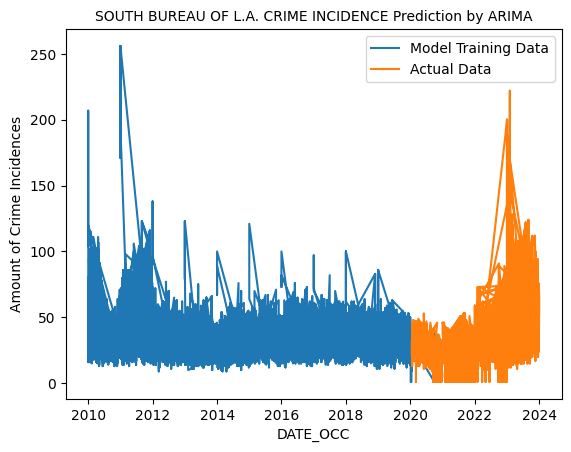

In [26]:
shape=south_dataset.shape[0]
df_new=south_dataset[['Crime_Incidence']]
df_new.head()
train_set=df_new.iloc[:ceil(shape*0.80)]
valid_set=df_new.iloc[ceil(shape*0.80):]
print('---------------------------------------------------------------------------')
print('-----------SOUTH BUREAU OF L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------')
print('---------------------------------------------------------------------------')
print('Shape of Training Set',train_set.shape)
print('Shape of Validation Set',valid_set.shape)
print('RMSE value on validation set:',rmse)


plt.plot(train_set['Crime_Incidence'])
plt.plot(valid_set['Crime_Incidence'])
plt.xlabel('DATE_OCC',size=10)
plt.ylabel('Amount of Crime Incidences',size=10)
plt.title('SOUTH BUREAU OF L.A. CRIME INCIDENCE Prediction by ARIMA',size=10)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

**ARIMA for Central Bureau**

In [27]:
# Split the data into train and test sets
train_set = int(len(central_dataset) * 0.8)
train, test = central_dataset[:train_set], central_dataset[train_set:]

# Find the optimal order (p, d, q) for ARIMA model based on AIC or other criteria
# Here, we use the order (2, 1, 3) as an example
order = (2, 1, 3)

# Train the ARIMA model
model = ARIMA(train['Crime_Incidence'], order=order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Evaluate the model using mean squared error
mse = mean_squared_error(test['Crime_Incidence'], predictions)
rmse = np.sqrt(mse)
print('RMSE: %.2f' % rmse)

RMSE: 27.44


---------------------------------------------------------------------------
-----------CENTRAL BUREAU OF L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------
---------------------------------------------------------------------------
Shape of Training Set (535776, 1)
Shape of Validation Set (133943, 1)
RMSE value on validation set: 27.443491153848054


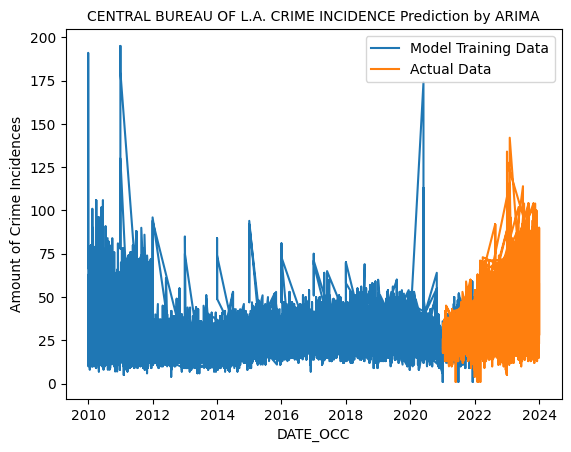

In [28]:
shape=central_dataset.shape[0]
df_new=central_dataset[['Crime_Incidence']]
df_new.head()
train_set=df_new.iloc[:ceil(shape*0.80)]
valid_set=df_new.iloc[ceil(shape*0.80):]
print('---------------------------------------------------------------------------')
print('-----------CENTRAL BUREAU OF L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------')
print('---------------------------------------------------------------------------')
print('Shape of Training Set',train_set.shape)
print('Shape of Validation Set',valid_set.shape)
print('RMSE value on validation set:',rmse)


plt.plot(train_set['Crime_Incidence'])
plt.plot(valid_set['Crime_Incidence'])
plt.xlabel('DATE_OCC',size=10)
plt.ylabel('Amount of Crime Incidences',size=10)
plt.title('CENTRAL BUREAU OF L.A. CRIME INCIDENCE Prediction by ARIMA',size=10)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])

**ARIMA for Valley Bureau**

In [29]:
# Split the data into train and test sets
train_set = int(len(valley_dataset) * 0.8)
train, test = valley_dataset[:train_set], valley_dataset[train_set:]

# Find the optimal order (p, d, q) for ARIMA model based on AIC or other criteria
# Here, we use the order (2, 1, 3) as an example
order = (2, 1, 3)

# Train the ARIMA model
model = ARIMA(train['Crime_Incidence'], order=order)
model_fit = model.fit()

# Make predictions
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Evaluate the model using mean squared error
mse = mean_squared_error(test['Crime_Incidence'], predictions)
rmse = np.sqrt(mse)
print('RMSE: %.2f' % rmse)

RMSE: 30.52


---------------------------------------------------------------------------
-----------VALLEY BUREAU OF L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------
---------------------------------------------------------------------------
Shape of Training Set (718508, 1)
Shape of Validation Set (179626, 1)
RMSE value on validation set: 30.518276552342524


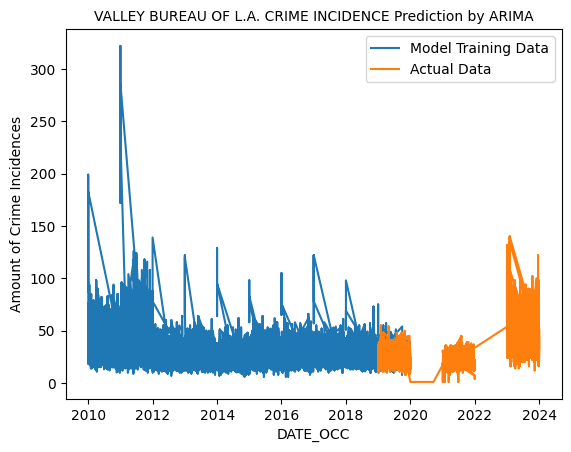

In [30]:
shape=valley_dataset.shape[0]
df_new=valley_dataset[['Crime_Incidence']]
df_new.head()
train_set=df_new.iloc[:ceil(shape*0.80)]
valid_set=df_new.iloc[ceil(shape*0.80):]
print('---------------------------------------------------------------------------')
print('-----------VALLEY BUREAU OF L.A. CRIME INCIDENCE PREDICTION BY ARIMA-----------------------')
print('---------------------------------------------------------------------------')
print('Shape of Training Set',train_set.shape)
print('Shape of Validation Set',valid_set.shape)
print('RMSE value on validation set:',rmse)


plt.plot(train_set['Crime_Incidence'])
plt.plot(valid_set['Crime_Incidence'])
plt.xlabel('DATE_OCC',size=10)
plt.ylabel('Amount of Crime Incidences',size=10)
plt.title('VALLEY BUREAU OF L.A. CRIME INCIDENCE Prediction by ARIMA',size=10)
plt.legend(['Model Training Data','Actual Data','Predicted Data'])